In [204]:
import os
import rasterio as rio
import pandas as pd
import geopandas as gpd
import morecantile
import pyproj
import requests
import lxml

from shapely.geometry import box

In [2]:
DATA_DIR = "/mnt/s3/proj-roadsurf/02_Data/initial/images_RS/"
SIRS_TK_SHPZIP = "zip:///mnt/s3/proj-roadsurf/02_Data/initial/images_RS/SIRS_TK.zip"


In [3]:
for f in os.listdir(DATA_DIR):
    print(f)

20180427_1430_12504_0_32.tfw
20180427_1430_12504_0_32.tif
20180427_1430_12504_0_33.tfw
20180427_1430_12504_0_33.tif
20180427_1430_12504_0_34.tfw
20180427_1430_12504_0_34.tif
20180427_1430_12504_0_35.tfw
20180427_1430_12504_0_35.tif
20180427_1430_12504_0_36.tfw
20180427_1430_12504_0_36.tif
SIRS_TK.zip


In [372]:
with rio.open(os.path.join(DATA_DIR, "20180427_1430_12504_0_32.tif")) as ds:
    print(ds.width, ds.height)
    print(ds.bounds)
    print(dir(ds))
    print(ds.crs)
    
    #print(ds.statistics(bidx=1, approx=True, clear_cache=True))

12800 16806
BoundingBox(left=2619471.5, bottom=1192519.3, right=2620751.5, top=1194199.9000000001)
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_block_shapes', '_closed', '_count', '_crs', '_crs_wkt', '_descriptions', '_dtypes', '_env', '_gcps', '_get_crs', '_get_rpcs', '_handle_crswkt', '_has_band', '_has_gcps_or_rpcs', '_mask_flags', '_nodatavals', '_offsets', '_read', '_rpcs', '_scales', '_set_all_descriptions', '_set_all_offsets', '_set_all_scales', '_set_all_units', '_set_attrs_from_dataset_handle', '_set_crs', '_set_gcps', '_set_nodatavals', '_set_rpcs', '_transform', '_units', 'block_shapes', 'block_size', 'block_window', 'bl

In [357]:
? ds.statistics

Docstring:
Get min, max, mean, and standard deviation of a raster band.

Parameters
----------
bidx : int
    The band's index (1-indexed).
approx : bool, optional
    If True, statistics will be calculated from reduced
    resolution data.
clear_cache : bool, optional
    If True, saved stats will be deleted and statistics will be
    recomputed. Requires GDAL version >= 3.2.

Returns
-------
Statistics

Notes
-----
GDAL will preferentially use statistics kept in raster metadata
like images tags or an XML sidecar. If that metadata is out of
date, the statistics may not correspond to the actual data.

Additionally, GDAL will save statistics to file metadata as a
side effect if that metadata does not already exist.
Type:      builtin_function_or_method


In [359]:
ds.statistics(bidx=1, approx=True)

RasterioIOError: Dataset is closed: /mnt/s3/proj-roadsurf/02_Data/initial/images_RS/20180427_1430_12504_0_32.tif

In [5]:
sirs_tk_df = gpd.read_file(SIRS_TK_SHPZIP)

In [6]:
sirs_tk_df.sort_values(by='ID').iloc[0]

ID                                   20180427_1430_12504_0_32
LINE_ID                                   20180427_1430_12504
geometry    POLYGON ((2619471.5 1192519.3, 2619471.5 11941...
Name: 153, dtype: object

In [7]:
sirs_tk_df.sort_values(by='ID').iloc[0].geometry.area

2151168.000000119

In [8]:
bboxes_gdf = gpd.GeoDataFrame()

for f in os.listdir(DATA_DIR):
    #print(f)
    if f.endswith('tif'):
        with rio.open(os.path.join(DATA_DIR, f), 'r') as ds:
            _geom = box(ds.bounds.left, ds.bounds.bottom, ds.bounds.right, ds.bounds.top)
            _df = pd.DataFrame.from_records([{"file": f}])
            _gdf = gpd.GeoDataFrame(_df, geometry=[_geom])
            #display(_gdf)
            bboxes_gdf = pd.concat([bboxes_gdf, _gdf])
            
bboxes_gdf.set_crs(epsg=2056, inplace=True)

,file,geometry
0,20180427_1430_12504_0_32.tif,"POLYGON ((2620751.500 1192519.300, 2620751.500..."
0,20180427_1430_12504_0_33.tif,"POLYGON ((2622031.500 1192535.600, 2622031.500..."
0,20180427_1430_12504_0_34.tif,"POLYGON ((2623311.500 1192534.300, 2623311.500..."
0,20180427_1430_12504_0_35.tif,"POLYGON ((2624591.500 1192564.100, 2624591.500..."
0,20180427_1430_12504_0_36.tif,"POLYGON ((2625871.500 1192510.800, 2625871.500..."


In [9]:
bboxes_gdf

,file,geometry
0,20180427_1430_12504_0_32.tif,"POLYGON ((2620751.500 1192519.300, 2620751.500..."
0,20180427_1430_12504_0_33.tif,"POLYGON ((2622031.500 1192535.600, 2622031.500..."
0,20180427_1430_12504_0_34.tif,"POLYGON ((2623311.500 1192534.300, 2623311.500..."
0,20180427_1430_12504_0_35.tif,"POLYGON ((2624591.500 1192564.100, 2624591.500..."
0,20180427_1430_12504_0_36.tif,"POLYGON ((2625871.500 1192510.800, 2625871.500..."


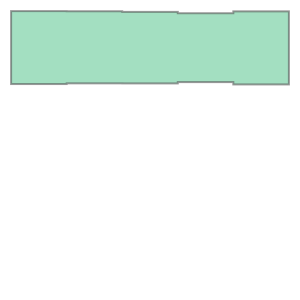

In [10]:
bboxes_gdf.unary_union

In [11]:
bboxes_gdf.unary_union.bounds

(2619471.5, 1192510.8, 2625871.5, 1194199.9000000001)

In [12]:
bboxes_extent_2056 = bboxes_gdf.unary_union.bounds
bboxes_extent_4326 = bboxes_gdf.to_crs(epsg=4326).unary_union.bounds

In [434]:
# cf. https://developmentseed.org/morecantile/usage/

crs_2056 = pyproj.CRS.from_epsg(2056)
crs_4326 = pyproj.CRS.from_epsg(4326)
crs_3857 = pyproj.CRS.from_epsg(3857)


# la bonne manière de générer un TMS pour la projection 2056:
extent_2056 = [2485071.58, 1075346.31, 2828515.82, 1299941.79] # cf. https://epsg.io/2056
tms = morecantile.TileMatrixSet.custom(extent=extent_2056, crs=crs_2056, identifier="My_custom_TMS")

epsg2056_z14_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[14])])
epsg2056_z14_tiles_gdf.set_crs(epsg=2056, inplace=True)
epsg2056_z14_tiles_gdf.to_file("output/epsg2056_z14_tiles.gpkg", driver="GPKG")



### 
tms = morecantile.tms.get("WebMercatorQuad")

epsg3857_z17_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[17])])
epsg3857_z17_tiles_gdf.set_crs(epsg=3857, inplace=True)
epsg3857_z17_tiles_gdf.to_file("output/epsg3857_z17_tiles.gpkg", driver="GPKG")

epsg3857_z18_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[18])])
epsg3857_z18_tiles_gdf.set_crs(epsg=3857, inplace=True)
epsg3857_z18_tiles_gdf.to_file("output/epsg3857_z18_tiles.gpkg", driver="GPKG")

# epsg3857_test_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[17, 18])])
# epsg3857_test_tiles_gdf.set_crs(epsg=3857, inplace=True)
# epsg3857_test_tiles_gdf.to_file("output/epsg3857_test_tiles.gpkg", driver="GPKG")

# geo.admin.ch fait différement...

/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: CRS is no longer part of the GeoJSON specification.Other projection than EPSG:4326 might not be supported.
  warnings.warn(
/home/acerioni/venv/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: CRS is no longer part of the GeoJSON specification.Other projection than EPSG:4326 might not be supported.
  warnings.warn(
/home/acerioni/venv/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: 

In [435]:
morecantile.tms.list()

['WorldCRS84Quad',
 'UPSAntarcticWGS84Quad',
 'NZTM2000',
 'WGS1984Quad',
 'NZTM2000Quad',
 'EuropeanETRS89_LAEAQuad',
 'CanadianNAD83_LCC',
 'WebMercatorQuad',
 'WorldMercatorWGS84Quad',
 'LINZAntarticaMapTilegrid',
 'UTM31WGS84Quad',
 'UPSArcticWGS84Quad']

In [390]:
bboxes_extent_4326

(7.6940925048526845, 46.88321481597479, 7.778152103876776, 46.89862634008234)

In [433]:
tms = morecantile.tms.get("WebMercatorQuad")

for tile in tms.tiles(*bboxes_extent_4326, zooms=[13, 14] ):
    #print(json.dumps(tms.feature(tile, projected=True), indent=4))
    print(tile)
    #break
    
#print(len(list(tms.tiles(*bboxes_extent_4326, zooms=[13, 14] ))))

Tile(x=4271, y=2884, z=13)
Tile(x=4271, y=2885, z=13)
Tile(x=4272, y=2884, z=13)
Tile(x=4272, y=2885, z=13)
Tile(x=8542, y=5769, z=14)
Tile(x=8542, y=5770, z=14)
Tile(x=8543, y=5769, z=14)
Tile(x=8543, y=5770, z=14)
Tile(x=8544, y=5769, z=14)
Tile(x=8544, y=5770, z=14)
Tile(x=8545, y=5769, z=14)
Tile(x=8545, y=5770, z=14)


In [436]:
# TileMatrixSet "2056_28" - https://wmts.geo.admin.ch/EPSG/2056/1.0.0/WMTSCapabilities.xml

PIXEL_TO_M = 0.00028 # (cf. https://gis.stackexchange.com/questions/315881/what-is-wmts-scaledenominator)

xmin, ymax = (2420000.0, 1350000.0)
scale_denominator = 14285714.285714287
tile_width = 256
tile_height = 256

xmax = xmin + scale_denominator * PIXEL_TO_M * tile_width
ymin = ymax - scale_denominator * PIXEL_TO_M * tile_height

xmin, ymin, xmax, ymax

(2420000.0, 326000.0, 3444000.0, 1350000.0)

In [437]:
crs_2056

<Derived Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [175]:
extent_geo_admin_ch_2056 = [xmin, ymin, xmax, ymax]
tms = morecantile.TileMatrixSet.custom(extent=extent_geo_admin_ch_2056, extent_crs=crs_2056, crs=crs_2056, identifier="My_custom_TMS")

In [177]:
#crs_2056.area_of_use.bounds

In [182]:
tms.matrix(0).dict(exclude_none=True)

{'type': 'TileMatrixType',
 'identifier': '0',
 'scaleDenominator': 14285714.285714287,
 'topLeftCorner': (2420000.0, 1350000.0),
 'tileWidth': 256,
 'tileHeight': 256,
 'matrixWidth': 1,
 'matrixHeight': 1}

In [ ]:
# OK, c'est conforme à ce qui est renvoyé par https://wmts.geo.admin.ch/EPSG/2056/1.0.0/WMTSCapabilities.xml

In [197]:
tms.matrix(1).dict(exclude_none=True)

{'type': 'TileMatrixType',
 'identifier': '1',
 'scaleDenominator': 7142857.142857144,
 'topLeftCorner': (2420000.0, 1350000.0),
 'tileWidth': 256,
 'tileHeight': 256,
 'matrixWidth': 2,
 'matrixHeight': 2}

In [183]:
# KO, ce n'est PAS conforme à ce qui est renvoyé par https://wmts.geo.admin.ch/EPSG/2056/1.0.0/WMTSCapabilities.xml !

In [184]:
for tile in tms.tiles(*bboxes_extent_4326, zooms=[3]):
    print(tile)
    print(tms.feature(tile))
    print()

Tile(x=1, y=1, z=3)
{'type': 'Feature', 'bbox': [6.753041083885727, 45.9932897589024, 8.440613175139863, 47.14897266650572], 'id': 'Tile(x=1, y=1, z=3)', 'geometry': {'type': 'Polygon', 'coordinates': [[[6.753041083885727, 45.9932897589024], [6.753041083885727, 47.14897266650572], [8.440613175139863, 47.14897266650572], [8.440613175139863, 45.9932897589024], [6.753041083885727, 45.9932897589024]]]}, 'properties': {'title': 'XYZ tile Tile(x=1, y=1, z=3)', 'grid_name': 'My_custom_TMS', 'grid_crs': 'EPSG:2056'}}



In [185]:
#z0_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[0])])
#z0_tiles_gdf.set_crs(epsg=2056, inplace=True)
#z0_tiles_gdf.to_file("output/z0_tiles.gpkg", driver="GPKG")

/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: CRS is no longer part of the GeoJSON specification.Other projection than EPSG:4326 might not be supported.
  warnings.warn(
/home/acerioni/venv/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [186]:
#z3_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[3])])
#z3_tiles_gdf.set_crs(epsg=2056, inplace=True)
#z3_tiles_gdf.to_file("output/z3_tiles.gpkg", driver="GPKG")

/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: CRS is no longer part of the GeoJSON specification.Other projection than EPSG:4326 might not be supported.
  warnings.warn(
/home/acerioni/venv/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [187]:
#z2_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[2])])
#z2_tiles_gdf.set_crs(epsg=2056, inplace=True)
#z2_tiles_gdf.to_file("output/z2_tiles.gpkg", driver="GPKG")

/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: CRS is no longer part of the GeoJSON specification.Other projection than EPSG:4326 might not be supported.
  warnings.warn(
/home/acerioni/venv/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [325]:
#z12_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[12])])
#z12_tiles_gdf.set_crs(epsg=2056, inplace=True)
#z12_tiles_gdf.to_file("output/z12_tiles.gpkg", driver="GPKG")

In [326]:
cnt = 0
for tile in tms.tiles(*bboxes_extent_4326, zooms=[12]):
    feat = tms.feature(tile, projected=True) 
    cnt += 1
    if cnt > 10000:
        break

print(cnt)

1


/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: CRS is no longer part of the GeoJSON specification.Other projection than EPSG:4326 might not be supported.
  warnings.warn(


In [327]:
tms.boundingBox

TMSBoundingBox(type='BoundingBoxType', crs=<Derived Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich
, lowerCorner=(2420000.0, 326000.0), upperCorner=(3444000.0, 1350000.0))

In [328]:
tms.xy_bbox

BoundingBox(left=2420000.0, bottom=326000.0, right=3444000.0, top=1350000.0)

In [376]:
xmin, ymin, xmax, ymax

(2420000.0, 326000.0, 3444000.0, 1350000.0)

In [330]:
res = requests.get("https://wmts.geo.admin.ch/EPSG/2056/1.0.0/WMTSCapabilities.xml")
wmts_capabilities_str = res.content

#wmts_capabilities
wmts_capabilities_parsed = lxml.etree.fromstring(wmts_capabilities_str)

In [331]:
wmts_capabilities_parsed

<Element {http://www.opengis.net/wmts/1.0}Capabilities at 0x7f4ad34e0100>

In [332]:
#wmts_capabilities_parsed.findall(".//{http://www.opengis.net/wmts/1.0}TileMatrixSet")

In [333]:
#wmts_capabilities_parsed.findall(".//ows:Identifier", namespaces={'ows': 'http://www.opengis.net/ows/1.1'})

In [335]:
res = wmts_capabilities_parsed.findall('.//*[ows:Identifier="2056_28"]/ows:Identifier', namespaces={'ows': 'http://www.opengis.net/ows/1.1'})
assert len(res) == 1

sel_tms = res[0].getparent()

In [336]:
sel_tms

<Element {http://www.opengis.net/wmts/1.0}TileMatrixSet at 0x7f4ad3386e80>

In [337]:
my_dict = {
    '{http://www.opengis.net/ows/1.1}Identifier': 'identifier',
    '{http://www.opengis.net/wmts/1.0}ScaleDenominator': 'scaleDenominator',
    '{http://www.opengis.net/wmts/1.0}TopLeftCorner': 'topLeftCorner',
    '{http://www.opengis.net/wmts/1.0}TileWidth': 'tileWidth',
    '{http://www.opengis.net/wmts/1.0}TileHeight': 'tileHeight',
    '{http://www.opengis.net/wmts/1.0}MatrixWidth': 'matrixWidth',
    '{http://www.opengis.net/wmts/1.0}MatrixHeight': 'matrixHeight'
}

In [338]:
def type_fixer(tm_dict):
    
    out_tm_dict = {}
    
    for k, v in tm_dict.items():
        
        if k == 'scaleDenominator':
            out_tm_dict[k] = float(tm_dict[k])
        elif k == 'topLeftCorner':
            out_tm_dict[k] = [float(x) for x in tm_dict[k].split(' ')]
        elif k in ['tileWidth', 'tileHeight', 'matrixWidth', 'matrixHeight']:
            out_tm_dict[k] = int(tm_dict[k])
        else:
            out_tm_dict[k] = tm_dict[k]
    
    return out_tm_dict
    

In [339]:
tm_list = []

for tm in sel_tms.findall("{http://www.opengis.net/wmts/1.0}TileMatrix"):
    _tm_dict = {}
    _tm_dict['type'] = "TileMatrixType"
    for child in tm:
        #print(child.tag, child.text)
        _tm_dict[my_dict[child.tag]] = child.text
        
    tm_list.append(type_fixer(_tm_dict))

In [340]:
#tm_list

In [341]:
def get_bbox_corners(tile_matrix_list):
    
    res = list(filter(lambda x: x['identifier'] == '0', tile_matrix_list))
    assert len(res) == 1
    
    relevant_tile_matrix = res[0]
    print(relevant_tile_matrix)
    
    PIXEL_TO_M = 0.00028 # (cf. https://gis.stackexchange.com/questions/315881/what-is-wmts-scaledenominator)

    xmin, ymax = relevant_tile_matrix['topLeftCorner']
    scale_denominator = relevant_tile_matrix['scaleDenominator']
    tile_width = relevant_tile_matrix['tileWidth']
    tile_height = relevant_tile_matrix['tileHeight']

    xmax = xmin + scale_denominator * PIXEL_TO_M * tile_width
    ymin = ymax - scale_denominator * PIXEL_TO_M * tile_height
    
    return {'lowerCorner': [xmin, ymin], 'upperCorner': [xmax, ymax]}

In [342]:
get_bbox_corners(tm_list)

{'type': 'TileMatrixType', 'identifier': '0', 'scaleDenominator': 14285714.285714287, 'topLeftCorner': [2420000.0, 1350000.0], 'tileWidth': 256, 'tileHeight': 256, 'matrixWidth': 1, 'matrixHeight': 1}


{'lowerCorner': [2420000.0, 326000.0], 'upperCorner': [3444000.0, 1350000.0]}

In [343]:
tms_dict = {
    "type": "TileMatrixSetType",
    "title": "My TMS",
    "identifier": "My_TMS",
    "boundingBox": {
        "type": "BoundingBoxType",
        "crs": "urn:ogc:def:crs:EPSG::2056",
        **get_bbox_corners(tm_list)
    },
    "supportedCRS": "urn:ogc:def:crs:EPSG::2056",
    "tileMatrix": tm_list
}

{'type': 'TileMatrixType', 'identifier': '0', 'scaleDenominator': 14285714.285714287, 'topLeftCorner': [2420000.0, 1350000.0], 'tileWidth': 256, 'tileHeight': 256, 'matrixWidth': 1, 'matrixHeight': 1}


In [344]:
import json

with open('output/2056_58.json', 'w') as fp:
    json.dump(tms_dict, fp)

In [350]:
tms_dict

{'type': 'TileMatrixSetType',
 'title': 'My TMS',
 'identifier': 'My_TMS',
 'boundingBox': {'type': 'BoundingBoxType',
  'crs': 'urn:ogc:def:crs:EPSG::2056',
  'lowerCorner': [2420000.0, 326000.0],
  'upperCorner': [3444000.0, 1350000.0]},
 'supportedCRS': 'urn:ogc:def:crs:EPSG::2056',
 'tileMatrix': [{'type': 'TileMatrixType',
   'identifier': '0',
   'scaleDenominator': 14285714.285714287,
   'topLeftCorner': [2420000.0, 1350000.0],
   'tileWidth': 256,
   'tileHeight': 256,
   'matrixWidth': 1,
   'matrixHeight': 1},
  {'type': 'TileMatrixType',
   'identifier': '1',
   'scaleDenominator': 13392857.142857144,
   'topLeftCorner': [2420000.0, 1350000.0],
   'tileWidth': 256,
   'tileHeight': 256,
   'matrixWidth': 1,
   'matrixHeight': 1},
  {'type': 'TileMatrixType',
   'identifier': '2',
   'scaleDenominator': 12500000.000000002,
   'topLeftCorner': [2420000.0, 1350000.0],
   'tileWidth': 256,
   'tileHeight': 256,
   'matrixWidth': 1,
   'matrixHeight': 1},
  {'type': 'TileMatrixTy

In [444]:
tms = morecantile.TileMatrixSet.parse_file('output/2056_58.json')
tms.boundingBox

TMSBoundingBox(type='BoundingBoxType', crs=<Derived Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich
, lowerCorner=(2420000.0, 326000.0), upperCorner=(3444000.0, 1350000.0))

In [446]:
tms.matrix(10).dict(exclude_none=True)

{'type': 'TileMatrixType',
 'identifier': '10',
 'scaleDenominator': 5357142.857142857,
 'topLeftCorner': (2420000.0, 1350000.0),
 'tileWidth': 256,
 'tileHeight': 256,
 'matrixWidth': 2,
 'matrixHeight': 1}

In [349]:
z12_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[12])])
z12_tiles_gdf.set_crs(epsg=2056, inplace=True)
z12_tiles_gdf.to_file("output/z12_tiles.gpkg", driver="GPKG")

z24_tiles_gdf = gpd.GeoDataFrame.from_features([tms.feature(x, projected=True) for x in tms.tiles(*bboxes_extent_4326, zooms=[24])])
z24_tiles_gdf.set_crs(epsg=2056, inplace=True)
z24_tiles_gdf.to_file("output/z24_tiles.gpkg", driver="GPKG")

/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: CRS is no longer part of the GeoJSON specification.Other projection than EPSG:4326 might not be supported.
  warnings.warn(
/home/acerioni/venv/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/acerioni/venv/lib/python3.8/site-packages/morecantile/models.py:849: UserWarning: CRS is no longer part of the GeoJSON specification.Other projection than EPSG:4326 might not be supported.
  warnings.warn(
/home/acerioni/venv/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [381]:
list(range(1,4))

[1, 2, 3]